# **Step 1. EDA + Embeddings Generation**

![Descripción de la imagen](https://drive.google.com/uc?id=1fWzFq-TOMPX0sy-zesVkjJot0cikPT7q)

En este script se realiza un EDA inicial sobre el dataset FEVER y se codifican los claims y páginas de wikipedia en embeddings usando el modelo BGE (size: 384).

El primer paso consiste en transformar los embeddings de los claims del dataset FEVER, junto con los embeddings de sus evidencias y almacenarlas en una unidad de almacenamiento intermedia.

In [ ]:
%pip install datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.0 MB/s eta 0:00:00


In [ ]:
### Librerías y código extra, necesario para la ejecución completa del cuaderno

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize

# Para cargar datasets del HUB de HuggingFace
from datasets import load_dataset
from datasets import Dataset, DownloadConfig

import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import torch

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

import gc
from huggingface_hub import HfApi


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive


## **Análisis y Arreglo**

En las siguientes celdas se explora el dataset FEVER. En el dataset, el campo evidence contiene un mix de tipos (enteros y cadenas). Al cargar los datos usando load_dataset de HuggingFace, aparece un error al convertir las cadenas a enteros. Por tanto, se deben procesar los archivos train/val/test.jsonl, convirtiendo las evidencias en cadenas.

In [ ]:
df_train = pd.read_json('/content/drive/MyDrive/Universidad/Master/TFM/Code/FEVER_raw/train.jsonl', lines=True)
df_val = pd.read_json('/content/drive/MyDrive/Universidad/Master/TFM/Code/FEVER_raw/val.jsonl', lines=True)
df_test = pd.read_json('/content/drive/MyDrive/Universidad/Master/TFM/Code/FEVER_raw/test.jsonl', lines=True)

#### **Train**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145449 entries, 0 to 145448
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          145449 non-null  int64 
 1   verifiable  145449 non-null  object
 2   label       145449 non-null  object
 3   claim       145449 non-null  object
 4   evidence    145449 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.5+ MB


- Mas cosas que puedo hacer de analisis:
1. media de tokens claims de cada clase
2. claims verificables y no verificables de cada clase
3. numero de evidencias media entre clases

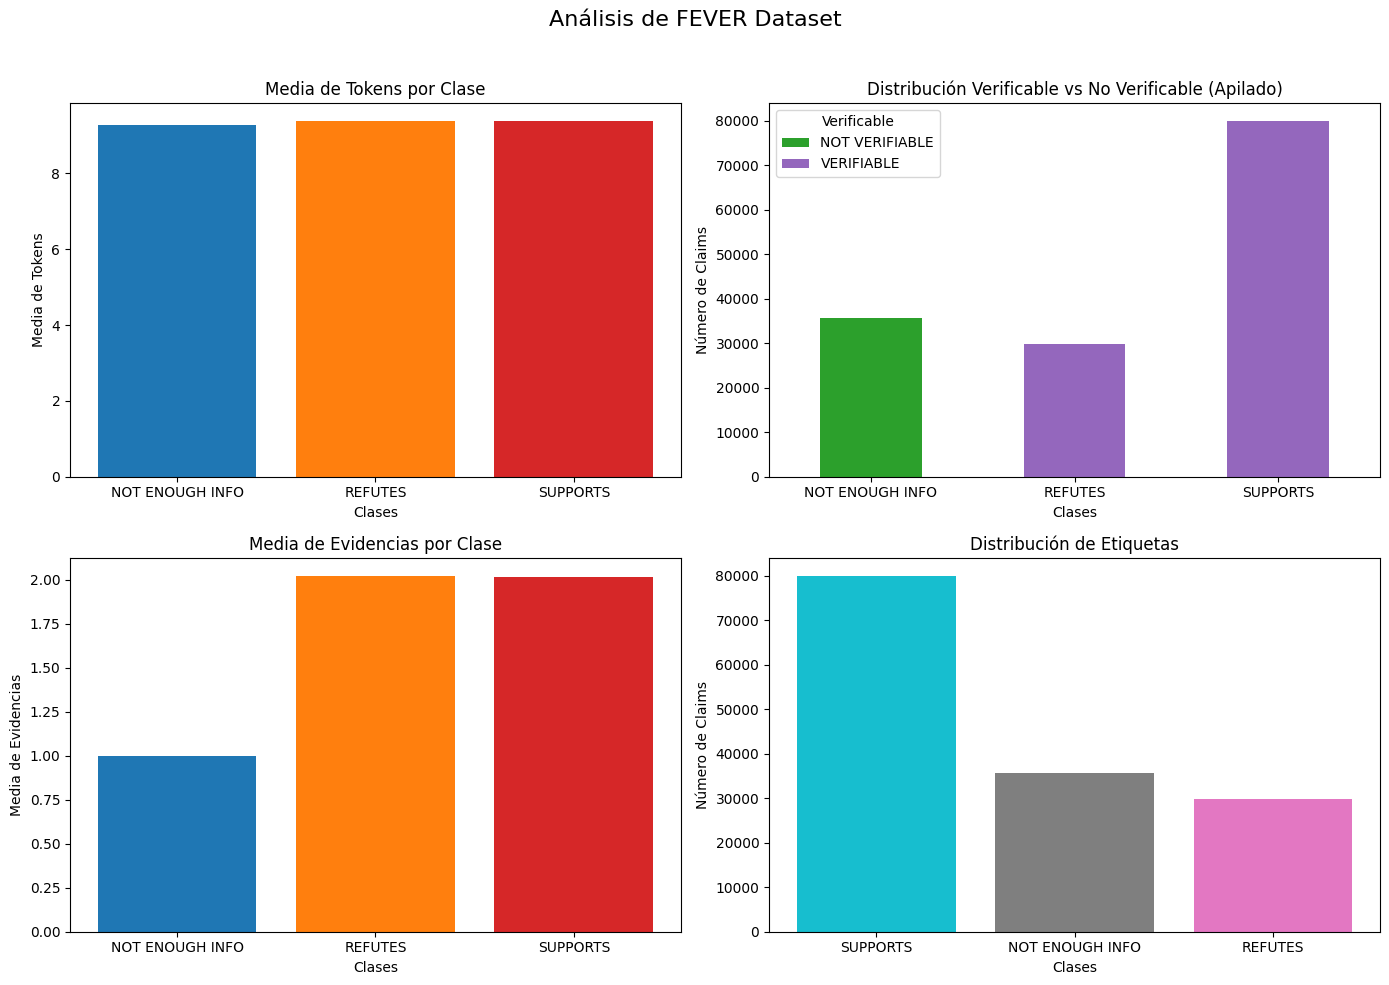

In [ ]:
def visualization_dataset(df):
  # Calcula la longitud en tokens de cada claim
  df['claim_length'] = df['claim'].apply(lambda x: len(word_tokenize(x)))

  # Número medio de tokens de los claims por clase
  mean_tokens_per_class = df.groupby('label')['claim_length'].mean()

  # Distribución de claims verificables y no verificables por clase
  verifiable_grouped = df.groupby(['label', 'verifiable']).size().unstack(fill_value=0)

  # Número medio de evidencias por clase
  df['num_evidences'] = df['evidence'].apply(lambda x: len(x) if isinstance(x, list) else 0)
  mean_evidences_per_class = df.groupby('label')['num_evidences'].mean()

  fig, axes = plt.subplots(2, 2, figsize=(14, 10))
  fig.suptitle('Análisis de FEVER Dataset', fontsize=16)

  # Subplot 1: Media de tokens de los claims por clase
  axes[0, 0].bar(mean_tokens_per_class.index, mean_tokens_per_class.values, color=['tab:blue', 'tab:orange', 'tab:red'])
  axes[0, 0].set_title('Media de Tokens por Clase')
  axes[0, 0].set_ylabel('Media de Tokens')
  axes[0, 0].set_xlabel('Clases')

  # Subplot 2: Claims verificables y no verificables por clase
  verifiable_grouped.plot(kind='bar', ax=axes[0, 1], stacked=True, color=['tab:green', 'tab:purple'])
  axes[0, 1].set_title('Distribución Verificable vs No Verificable (Apilado)')
  axes[0, 1].set_ylabel('Número de Claims')
  axes[0, 1].set_xlabel('Clases')
  axes[0, 1].legend(title="Verificable")
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)  # Horizontal

  # Subplot 3: Número medio de evidencias por clase
  axes[1, 0].bar(mean_evidences_per_class.index, mean_evidences_per_class.values, color=['tab:blue', 'tab:orange', 'tab:red'])
  axes[1, 0].set_title('Media de Evidencias por Clase')
  axes[1, 0].set_ylabel('Media de Evidencias')
  axes[1, 0].set_xlabel('Clases')

  # Subplot 4: Distribución de las etiquetas
  label_counts = df_train['label'].value_counts()
  axes[1, 1].bar(label_counts.index, label_counts.values, color=['tab:cyan', 'tab:gray', 'tab:pink'])
  axes[1, 1].set_title('Distribución de Etiquetas')
  axes[1, 1].set_ylabel('Número de Claims')
  axes[1, 1].set_xlabel('Clases')

  plt.tight_layout(rect=[0, 0, 1, 0.96]) # Espacios entre los subplots
  plt.show()

  df.drop(columns=['claim_length'], inplace=True)
  df.drop(columns=['num_evidences'], inplace=True)

visualization_dataset(df_train)

In [ ]:
df_train.head(5)

,id,verifiable,label,claim,evidence
0,75397,VERIFIABLE,SUPPORTS,Nikolaj Coster-Waldau worked with the Fox Broa...,"[[[92206, 104971, Nikolaj_Coster-Waldau, 7], [..."
1,150448,VERIFIABLE,SUPPORTS,Roman Atwood is a content creator.,"[[[174271, 187498, Roman_Atwood, 1]], [[174271..."
2,214861,VERIFIABLE,SUPPORTS,"History of art includes architecture, dance, s...","[[[255136, 254645, History_of_art, 2]]]"
3,156709,VERIFIABLE,REFUTES,Adrienne Bailon is an accountant.,"[[[180804, 193183, Adrienne_Bailon, 0]]]"
4,83235,NOT VERIFIABLE,NOT ENOUGH INFO,System of a Down briefly disbanded in limbo.,"[[[100277, None, None, None]]]"


In [ ]:
df_train["evidence"].iloc[3]

[[[180804, 193183, 'Adrienne_Bailon', 0]]]

In [ ]:
def transform_evidence(evidence_list):
    transformed = []

    for evidence in evidence_list[0]:  # evidence_list[0] para acceder a la lista de evidencias
        transformed.append([str(e) if e is not None else 'None' for e in evidence])

    return transformed

df_train['evidence'] = df_train['evidence'].apply(lambda x: transform_evidence(x))

df_train.to_json('/content/drive/MyDrive/Universidad/Master/TFM/Code/FEVER_raw/train_fixed.jsonl', orient='records', lines=True)

#### **Val**

In [ ]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          19998 non-null  int64 
 1   verifiable  19998 non-null  object
 2   label       19998 non-null  object
 3   claim       19998 non-null  object
 4   evidence    19998 non-null  object
dtypes: int64(1), object(4)
memory usage: 781.3+ KB


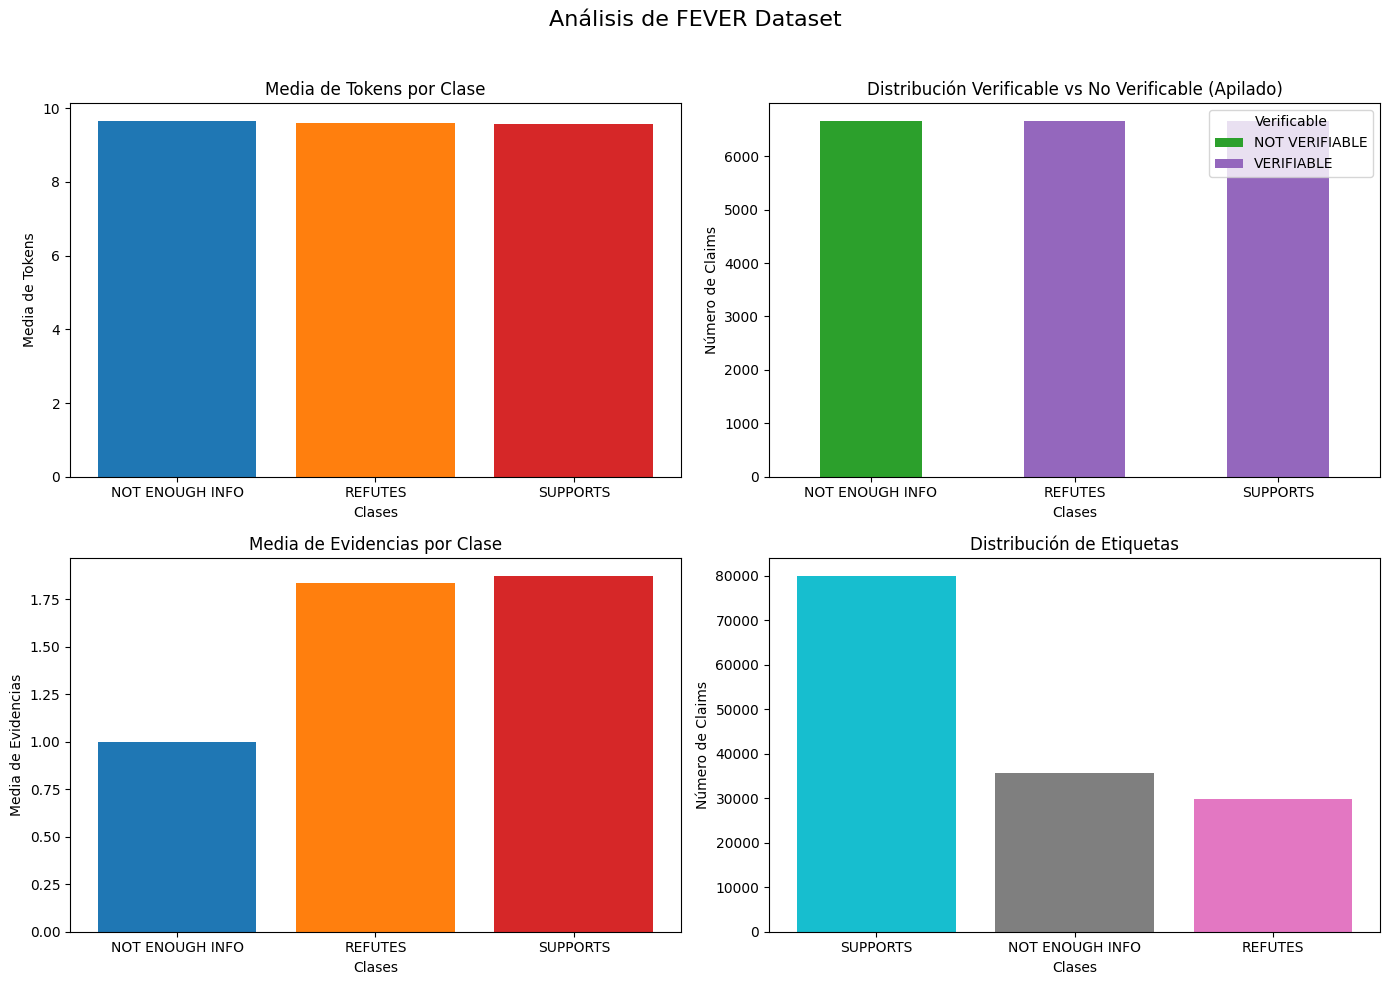

In [ ]:
visualization_dataset(df_val)

In [ ]:
df_val.head(5)

,id,verifiable,label,claim,evidence
0,91198,NOT VERIFIABLE,NOT ENOUGH INFO,Colin Kaepernick became a starting quarterback...,"[[[108548, None, None, None]]]"
1,194462,NOT VERIFIABLE,NOT ENOUGH INFO,Tilda Swinton is a vegan.,"[[[227768, None, None, None]]]"
2,137334,VERIFIABLE,SUPPORTS,Fox 2000 Pictures released the film Soul Food.,"[[[289914, 283015, Soul_Food_-LRB-film-RRB-, 0..."
3,166626,NOT VERIFIABLE,NOT ENOUGH INFO,Anne Rice was born in New Jersey.,"[[[191656, None, None, None], [191657, None, N..."
4,111897,VERIFIABLE,REFUTES,Telemundo is a English-language television net...,"[[[131371, 146144, Telemundo, 0]], [[131371, 1..."


In [ ]:
df_val['evidence'] = df_val['evidence'].apply(lambda x: transform_evidence(x))
df_val.to_json('/content/drive/MyDrive/Universidad/Master/TFM/Code/FEVER_raw/val_fixed.jsonl', orient='records', lines=True)

In [ ]:
df_val["evidence"].iloc[3]

[['191656', 'None', 'None', 'None'], ['191657', 'None', 'None', 'None']]



---


## **Preprocesado y Generación de Embeddings del Dataset almacenado en HuggingFace**

Una vez se almacenan los ficheros "train_fixed.jsonl", "val_fixed.jsonl" y "test.jsonl" en un repositorio de HuggingFace */JORGEDC01/Demo1*, a continuación se cargan con el objetivo de transformar los *claims* y las evidencias en embeddings.

Los embeddings de las evidencias se pueden generar a nivel de frase o a nivel de artículo.

- Nivel artículo: las evidencias son frases que no están aisladas. La comprensión completa de una evidencia a veces depende del contexto del artículo. Algunas evidencias pueden no ser muy claras, su contexto no solo ayudará al modelo a detectar la evidencia, sino también a desechar aquella información poco relevante en la validación del claim.

  En el caso de no disponer de un módulo de *information retrieval* que devuelva los claims verificados, operar con los embeddings de los artículos es fundamental.

  Mediante este enfoque, al LLM no se le va a pasar la evidencia marcada en el input de entrada, sino que se le alimenta con todo el artículo de las evidencias y otros artículos no relacionados. En el mundo real, este enfoque permite que el sistema pueda operar sobre un entorno en el que no se dispongan los hechos verificados que puedan contrastar una claim.

- Nivel frase: el embedding a nivel de frase se utiliza en el *paper* Fact-Checker. En él, proponen una *pipeline* con un módulo de *information retrieval* y similitud semántica y un segundo módulo de inferencia del lenguaje natural (NLI). La idea consiste en recuperar los claims verificados de una base de datos externa, transformar los claims en embeddings mediante un ensemble de modelos y aplicar la distancia coseno entre el claim-input y los claims recuperados, filtrando y conservando aquellos mas proximos al claim que se desea verificar. A continuación, le pasan pares de evidencias + claim-input para que el modelo de inferencia de lenguaje clasifique la muestra como implicación, neutral o contradicción. En este caso, se verifica la hipótesis en base a premisas verificadas y semánticamente próximas a ella. Este enfoque es útil por contrastar la informacion con aquella ya verificada en fuentes fiables. Sin embargo, la capacidad de predicción del NLI puede verse afectada por el rendimiento del módulo IR.


▶
¡Por ahora, **La primera aproximación consiste en calcular los embeddings a nivel de artículo, incluyendo el contexto que rodea la evidencia**!

### **Carga de datos del repositorio de HuggingFace**

In [ ]:
from huggingface_hub import list_datasets

datasets = list_datasets(author="JORGEDC01")
print([d.id for d in datasets])

['JORGEDC01/Demo1']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Datos de entrenamiento, val y test
data_files = {"train": "train_fixed.jsonl", "val": "val_fixed.jsonl"}
download_config = DownloadConfig(disable_tqdm=True)
dataset = load_dataset("JORGEDC01/Demo1", data_dir="Data", data_files=data_files, download_config=download_config) # oontiene los datos de claims de FEVER
print(dataset)

#dataset_wikipages = load_dataset("JORGEDC01/Demo1", data_dir="wiki-pages", download_config=download_config, streaming=True) # Devuelve un IterableDataset o IterableDatasetDict con las wiki-pages
#print(dataset_wikipages)


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

train_fixed.jsonl:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

Data%2Fval_fixed.jsonl:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'verifiable', 'label', 'claim', 'evidence'],
        num_rows: 145449
    })
    val: Dataset({
        features: ['id', 'verifiable', 'label', 'claim', 'evidence'],
        num_rows: 19998
    })
})


In [ ]:
train_dataset = dataset['train']
val_dataset = dataset['val']

In [ ]:
type(train_dataset)

datasets.arrow_dataset.Dataset

In [ ]:
df_train = pd.DataFrame(train_dataset)
df_val = pd.DataFrame(val_dataset)

In [ ]:
df_train.head(5)

,id,verifiable,label,claim,evidence
0,75397,VERIFIABLE,SUPPORTS,Nikolaj Coster-Waldau worked with the Fox Broa...,"[[92206, 104971, Nikolaj_Coster-Waldau, 7], [9..."
1,150448,VERIFIABLE,SUPPORTS,Roman Atwood is a content creator.,"[[174271, 187498, Roman_Atwood, 1]]"
2,214861,VERIFIABLE,SUPPORTS,"History of art includes architecture, dance, s...","[[255136, 254645, History_of_art, 2]]"
3,156709,VERIFIABLE,REFUTES,Adrienne Bailon is an accountant.,"[[180804, 193183, Adrienne_Bailon, 0]]"
4,83235,NOT VERIFIABLE,NOT ENOUGH INFO,System of a Down briefly disbanded in limbo.,"[[100277, None, None, None]]"


In [ ]:
# iterable_wikipages = dataset_wikipages["train"]

### **Preprocesado**
No se van a eliminar los stopwords ni los signos de puntuación porque estos afectan negativamente al rendimiento de los transformers.

### **Generación por Inferencia**


#### BGE Encoder
Se escoge un primer transformer encoder preentrenado para calcular los embeddings. El modelo escogido es **BAAI/bge-small-en-v1.5**.
- Enlace del modelo en HuggingFace: https://huggingface.co/BAAI/bge-small-en-v1.5/tree/main
- Enlace del Repositorio de BGE en Github: https://github.com/FlagOpen/FlagEmbedding?tab=readme-ov-file#installation
- Implementación del modelo en Github: https://github.com/FlagOpen/FlagEmbedding/blob/master/FlagEmbedding/inference/embedder/encoder_only/base.py

Este modelo parte de un BERT-base con 12 capas de encoders y un espacio de dimensión de 384. Fue entrenado en la tarea de recuperación de información mediante similitud semántica de tripletas. Una muestra de entrenamiento es una tripleta <query, document_relevant, document_irrelevant>, y con una función de pérdida constrastiva, se ajusta el modelo para minimizar la distancia entre query y los documentos relevantes, mientras que se maximiza la distancia con los irrelevantes.

> Se procede a instalar el módulo de python que permite importar este modelo.

In [ ]:
%pip install -U FlagEmbedding[finetune] --quiet

from FlagEmbedding import FlagAutoModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.8/161.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from FlagEmbedding import FlagAutoModel

model = FlagAutoModel.from_finetuned('BAAI/bge-small-en-v1.5',
                                      query_instruction_for_retrieval="Represent this sentence for searching relevant passages:",
                                      use_fp16=False)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

##### **Claim Embeddings**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


> **Training set embeddings**

In [ ]:
claim_list = df_train['claim'].tolist()
embedding_1 = model.encode(claim_list, batch_size=512) # Por defecto, el modelo tiene batch_size de 200. Internamente _encode_ tokeniza, aunque realiza el padding a posteriori del tokenizer

pre tokenize: 100%|██████████| 285/285 [00:08<00:00, 33.49it/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 285/285 [00:28<00:00, 10.03it/s]


In [ ]:
df_train['claim_embedding'] = embedding_1.tolist()

In [ ]:
df_train.head(2)

,id,verifiable,label,claim,evidence,claim_embedding
0,75397,VERIFIABLE,SUPPORTS,Nikolaj Coster-Waldau worked with the Fox Broa...,"[[92206, 104971, Nikolaj_Coster-Waldau, 7], [9...","[-0.004876692779362202, 0.012141332030296326, ..."
1,150448,VERIFIABLE,SUPPORTS,Roman Atwood is a content creator.,"[[174271, 187498, Roman_Atwood, 1]]","[-0.0606420673429966, 0.06806661188602448, 0.0..."


In [ ]:
df_train.to_pickle('e_train.pkl')
df_train.to_json('e_train.jsonl', orient="records", lines=True)

In [ ]:
repo_id = "JORGEDC01/Demo1"
api = HfApi()
output_filename = "e_train.jsonl"

api.upload_file(
    path_or_fileobj=output_filename,
    path_in_repo=f"Data/Embeddings_Data/bge_small_en_v1.5/{output_filename}",
    repo_id=repo_id,
    repo_type="dataset"
)

output_filename = "e_train.pkl"

api.upload_file(
    path_or_fileobj=output_filename,
    path_in_repo=f"Data/Embeddings_Data/bge_small_en_v1.5/{output_filename}",
    repo_id=repo_id,
    repo_type="dataset"
)

e_train.jsonl:   0%|          | 0.00/777M [00:00<?, ?B/s]

e_train.pkl:   0%|          | 0.00/524M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/JORGEDC01/Demo1/commit/5589ce6710942b0b664983551001c7c7599bf780', commit_message='Upload Data/Embeddings_Data/bge_small_en_v1.5/e_train.pkl with huggingface_hub', commit_description='', oid='5589ce6710942b0b664983551001c7c7599bf780', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/JORGEDC01/Demo1', endpoint='https://huggingface.co', repo_type='dataset', repo_id='JORGEDC01/Demo1'), pr_revision=None, pr_num=None)

> **Development set embeddings**

In [ ]:
del df_train
del embedding_1
del claim_list

In [ ]:
claim_list = df_val['claim'].tolist()
embedding_1 = model.encode(claim_list, batch_size=512)

df_val['claim_embedding'] = embedding_1.tolist()

Inference Embeddings: 100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


In [ ]:
df_val.to_pickle('e_val.pkl')
df_val.to_json('e_val.jsonl', orient="records", lines=True)

In [ ]:
repo_id = "JORGEDC01/Demo1"
api = HfApi()
output_filename = "e_val.jsonl"

api.upload_file(
    path_or_fileobj=output_filename,
    path_in_repo=f"Data/Embeddings_Data/bge_small_en_v1.5/{output_filename}",
    repo_id=repo_id,
    repo_type="dataset"
)

output_filename = "e_val.pkl"

api.upload_file(
    path_or_fileobj=output_filename,
    path_in_repo=f"Data/Embeddings_Data/bge_small_en_v1.5/{output_filename}",
    repo_id=repo_id,
    repo_type="dataset"
)

e_val.jsonl:   0%|          | 0.00/107M [00:00<?, ?B/s]

e_val.pkl:   0%|          | 0.00/72.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/JORGEDC01/Demo1/commit/6dde6c37a033f85b36fb04e98681287e61514408', commit_message='Upload Data/Embeddings_Data/bge_small_en_v1.5/e_val.pkl with huggingface_hub', commit_description='', oid='6dde6c37a033f85b36fb04e98681287e61514408', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/JORGEDC01/Demo1', endpoint='https://huggingface.co', repo_type='dataset', repo_id='JORGEDC01/Demo1'), pr_revision=None, pr_num=None)

##### **Wiki-pages Embeddings**

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
def generate_wikiPages_embeddings(model, model_name):

  dataset_name = "JORGEDC01/Demo1"
  data_dir = "wiki-pages"

  for i in range(1, 101):  # Por cada fichero

      file_name = f"wiki-{str(i).zfill(3)}.jsonl"
      file_path = f"{data_dir}/{file_name}"
      print(file_name)

      download_config = DownloadConfig(disable_tqdm=True)
      dataset_file = load_dataset("JORGEDC01/Demo1", data_files={"train": file_path}, download_config=download_config)

      rows_file = dataset_file['train']
      df_file = pd.DataFrame(rows_file)

      print(f"Cargando {file_name}...")
      print(f"Tamaño del DataFrame: {df_file.shape}")

      texts = df_file['text'].tolist()
      embedding_texts = model.encode(texts, batch_size=512)

      df_file['text_embedding'] = embedding_texts.tolist()
      df_file.drop(columns=['lines'], inplace=True)

      output_filename = f"wiki-{str(i).zfill(3)}.pkl"
      df_file.to_pickle(output_filename)

      # Guarda archivo en el repositorio de HuggingFace
      api = HfApi()

      api.upload_file(
          path_or_fileobj=output_filename,
          path_in_repo=f"wiki-pages/Embeddings_WikiPages/{model_name}/{output_filename}",
          repo_id=dataset_name,
          repo_type="dataset"
      )

      del df_file, rows_file, texts, embedding_texts
      torch.cuda.empty_cache()  # la caché de la GPU
      gc.collect()

generate_wikiPages_embeddings(model, "bge_small_en_v1.5")

wiki-001.jsonl


Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-001.jsonl...
Tamaño del DataFrame: (49999, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:16<00:00,  1.28it/s]


wiki-002.jsonl


Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-002.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:17<00:00,  1.26it/s]


wiki-003.jsonl


wiki-003.jsonl:   0%|          | 0.00/61.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-003.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


wiki-003.pkl:   0%|          | 0.00/197M [00:00<?, ?B/s]

wiki-004.jsonl


wiki-004.jsonl:   0%|          | 0.00/62.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-004.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:29<00:00,  1.09it/s]


wiki-004.pkl:   0%|          | 0.00/198M [00:00<?, ?B/s]

wiki-005.jsonl


wiki-005.jsonl:   0%|          | 0.00/66.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-005.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]


wiki-005.pkl:   0%|          | 0.00/199M [00:00<?, ?B/s]

wiki-006.jsonl


wiki-006.jsonl:   0%|          | 0.00/66.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-006.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:43<00:00,  1.06s/it]


wiki-006.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-007.jsonl


wiki-007.jsonl:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-007.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]


wiki-007.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-008.jsonl


wiki-008.jsonl:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-008.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]


wiki-008.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-009.jsonl


wiki-009.jsonl:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-009.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]


wiki-009.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-010.jsonl


wiki-010.jsonl:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-010.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-010.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-011.jsonl


wiki-011.jsonl:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-011.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]


wiki-011.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-012.jsonl


wiki-012.jsonl:   0%|          | 0.00/67.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-012.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it]


wiki-012.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-013.jsonl


wiki-013.jsonl:   0%|          | 0.00/67.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-013.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


wiki-013.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-014.jsonl


wiki-014.jsonl:   0%|          | 0.00/72.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-014.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.14s/it]


wiki-014.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-015.jsonl


wiki-015.jsonl:   0%|          | 0.00/73.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-015.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


wiki-015.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-016.jsonl


wiki-016.jsonl:   0%|          | 0.00/71.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-016.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-016.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-017.jsonl


wiki-017.jsonl:   0%|          | 0.00/70.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-017.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-017.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-018.jsonl


wiki-018.jsonl:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-018.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]


wiki-018.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-019.jsonl


wiki-019.jsonl:   0%|          | 0.00/67.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-019.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:44<00:00,  1.06s/it]


wiki-019.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-020.jsonl


wiki-020.jsonl:   0%|          | 0.00/69.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-020.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]


wiki-020.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-021.jsonl


wiki-021.jsonl:   0%|          | 0.00/70.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-021.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]


wiki-021.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-022.jsonl


wiki-022.jsonl:   0%|          | 0.00/72.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-022.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-022.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-023.jsonl


wiki-023.jsonl:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-023.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


wiki-023.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-024.jsonl


wiki-024.jsonl:   0%|          | 0.00/73.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-024.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


wiki-024.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-025.jsonl


wiki-025.jsonl:   0%|          | 0.00/69.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-025.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]


wiki-025.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-026.jsonl


wiki-026.jsonl:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-026.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-026.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-027.jsonl


wiki-027.jsonl:   0%|          | 0.00/72.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-027.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.14s/it]


wiki-027.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-028.jsonl


wiki-028.jsonl:   0%|          | 0.00/72.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-028.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-028.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-029.jsonl


wiki-029.jsonl:   0%|          | 0.00/72.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-029.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.14s/it]


wiki-029.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-030.jsonl


wiki-030.jsonl:   0%|          | 0.00/72.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-030.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-030.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-031.jsonl


wiki-031.jsonl:   0%|          | 0.00/71.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-031.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-031.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-032.jsonl


wiki-032.jsonl:   0%|          | 0.00/71.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-032.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-032.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-033.jsonl


wiki-033.jsonl:   0%|          | 0.00/69.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-033.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-033.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-034.jsonl


wiki-034.jsonl:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-034.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]


wiki-034.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-035.jsonl


wiki-035.jsonl:   0%|          | 0.00/71.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-035.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-035.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-036.jsonl


wiki-036.jsonl:   0%|          | 0.00/73.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-036.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


wiki-036.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-037.jsonl


wiki-037.jsonl:   0%|          | 0.00/73.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-037.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


wiki-037.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-038.jsonl


wiki-038.jsonl:   0%|          | 0.00/72.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-038.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.13s/it]


wiki-038.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-039.jsonl


wiki-039.jsonl:   0%|          | 0.00/72.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-039.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


wiki-039.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-040.jsonl


wiki-040.jsonl:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-040.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]


wiki-040.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-041.jsonl


wiki-041.jsonl:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-041.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-041.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-042.jsonl


wiki-042.jsonl:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-042.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-042.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-043.jsonl


wiki-043.jsonl:   0%|          | 0.00/70.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-043.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]


wiki-043.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-044.jsonl


wiki-044.jsonl:   0%|          | 0.00/72.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-044.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-044.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-045.jsonl


wiki-045.jsonl:   0%|          | 0.00/75.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-045.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:53<00:00,  1.15s/it]


wiki-045.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-046.jsonl


wiki-046.jsonl:   0%|          | 0.00/75.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-046.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:53<00:00,  1.16s/it]


wiki-046.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-047.jsonl


wiki-047.jsonl:   0%|          | 0.00/77.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-047.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:55<00:00,  1.18s/it]


wiki-047.pkl:   0%|          | 0.00/204M [00:00<?, ?B/s]

wiki-048.jsonl


wiki-048.jsonl:   0%|          | 0.00/75.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-048.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:55<00:00,  1.18s/it]


wiki-048.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-049.jsonl


wiki-049.jsonl:   0%|          | 0.00/73.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-049.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:54<00:00,  1.16s/it]


wiki-049.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-050.jsonl


wiki-050.jsonl:   0%|          | 0.00/73.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-050.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:53<00:00,  1.16s/it]


wiki-050.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-051.jsonl


wiki-051.jsonl:   0%|          | 0.00/71.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-051.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-051.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-052.jsonl


wiki-052.jsonl:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-052.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.14s/it]


wiki-052.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-053.jsonl


wiki-053.jsonl:   0%|          | 0.00/65.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-053.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]


wiki-053.pkl:   0%|          | 0.00/199M [00:00<?, ?B/s]

wiki-054.jsonl


wiki-054.jsonl:   0%|          | 0.00/64.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-054.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:40<00:00,  1.03s/it]


wiki-054.pkl:   0%|          | 0.00/198M [00:00<?, ?B/s]

wiki-055.jsonl


wiki-055.jsonl:   0%|          | 0.00/65.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-055.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]


wiki-055.pkl:   0%|          | 0.00/198M [00:00<?, ?B/s]

wiki-056.jsonl


wiki-056.jsonl:   0%|          | 0.00/65.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-056.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]


wiki-056.pkl:   0%|          | 0.00/198M [00:00<?, ?B/s]

wiki-057.jsonl


wiki-057.jsonl:   0%|          | 0.00/72.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-057.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


wiki-057.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-058.jsonl


wiki-058.jsonl:   0%|          | 0.00/75.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-058.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-058.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-059.jsonl


wiki-059.jsonl:   0%|          | 0.00/76.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-059.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:43<00:00,  1.06s/it]


wiki-059.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-060.jsonl


wiki-060.jsonl:   0%|          | 0.00/76.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-060.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]


wiki-060.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-061.jsonl


wiki-061.jsonl:   0%|          | 0.00/73.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-061.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:42<00:00,  1.05s/it]


wiki-061.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-062.jsonl


wiki-062.jsonl:   0%|          | 0.00/67.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-062.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


wiki-062.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-063.jsonl


wiki-063.jsonl:   0%|          | 0.00/68.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-063.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]


wiki-063.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-064.jsonl


wiki-064.jsonl:   0%|          | 0.00/69.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-064.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]


wiki-064.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-065.jsonl


wiki-065.jsonl:   0%|          | 0.00/69.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-065.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]


wiki-065.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-066.jsonl


wiki-066.jsonl:   0%|          | 0.00/71.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-066.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]


wiki-066.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-067.jsonl


wiki-067.jsonl:   0%|          | 0.00/71.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-067.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-067.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-068.jsonl


wiki-068.jsonl:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-068.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]


wiki-068.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-069.jsonl


wiki-069.jsonl:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-069.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


wiki-069.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-070.jsonl


wiki-070.jsonl:   0%|          | 0.00/70.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-070.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.09s/it]


wiki-070.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-071.jsonl


wiki-071.jsonl:   0%|          | 0.00/72.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-071.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]


wiki-071.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-072.jsonl


wiki-072.jsonl:   0%|          | 0.00/71.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-072.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:49<00:00,  1.11s/it]


wiki-072.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-073.jsonl


wiki-073.jsonl:   0%|          | 0.00/71.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-073.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-073.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-074.jsonl


wiki-074.jsonl:   0%|          | 0.00/70.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-074.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-074.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-075.jsonl


wiki-075.jsonl:   0%|          | 0.00/68.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-075.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]


wiki-075.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-076.jsonl


wiki-076.jsonl:   0%|          | 0.00/69.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-076.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:48<00:00,  1.11s/it]


wiki-076.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-077.jsonl


wiki-077.jsonl:   0%|          | 0.00/71.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-077.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]


wiki-077.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-078.jsonl


wiki-078.jsonl:   0%|          | 0.00/71.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-078.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.12s/it]


wiki-078.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-079.jsonl


wiki-079.jsonl:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-079.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-079.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-080.jsonl


wiki-080.jsonl:   0%|          | 0.00/69.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-080.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]


wiki-080.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-081.jsonl


wiki-081.jsonl:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-081.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.14s/it]


wiki-081.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-082.jsonl


wiki-082.jsonl:   0%|          | 0.00/72.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-082.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


wiki-082.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-083.jsonl


wiki-083.jsonl:   0%|          | 0.00/72.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-083.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-083.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-084.jsonl


wiki-084.jsonl:   0%|          | 0.00/72.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-084.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-084.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-085.jsonl


wiki-085.jsonl:   0%|          | 0.00/68.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-085.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


wiki-085.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-086.jsonl


wiki-086.jsonl:   0%|          | 0.00/65.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-086.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:41<00:00,  1.03s/it]


wiki-086.pkl:   0%|          | 0.00/199M [00:00<?, ?B/s]

wiki-087.jsonl


wiki-087.jsonl:   0%|          | 0.00/66.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-087.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:43<00:00,  1.05s/it]


wiki-087.pkl:   0%|          | 0.00/199M [00:00<?, ?B/s]

wiki-088.jsonl


wiki-088.jsonl:   0%|          | 0.00/69.7M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-088.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:47<00:00,  1.10s/it]


wiki-088.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-089.jsonl


wiki-089.jsonl:   0%|          | 0.00/71.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-089.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]


wiki-089.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-090.jsonl


wiki-090.jsonl:   0%|          | 0.00/73.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-090.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.13s/it]


wiki-090.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-091.jsonl


wiki-091.jsonl:   0%|          | 0.00/72.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-091.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.14s/it]


wiki-091.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-092.jsonl


wiki-092.jsonl:   0%|          | 0.00/72.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-092.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-092.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-093.jsonl


wiki-093.jsonl:   0%|          | 0.00/71.8M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-093.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-093.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-094.jsonl


wiki-094.jsonl:   0%|          | 0.00/68.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-094.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]


wiki-094.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-095.jsonl


wiki-095.jsonl:   0%|          | 0.00/67.5M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-095.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it]


wiki-095.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-096.jsonl


wiki-096.jsonl:   0%|          | 0.00/72.3M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-096.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:52<00:00,  1.14s/it]


wiki-096.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-097.jsonl


wiki-097.jsonl:   0%|          | 0.00/73.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-097.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:53<00:00,  1.16s/it]


wiki-097.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-098.jsonl


wiki-098.jsonl:   0%|          | 0.00/71.4M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-098.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:50<00:00,  1.13s/it]


wiki-098.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-099.jsonl


wiki-099.jsonl:   0%|          | 0.00/70.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-099.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]


wiki-099.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-100.jsonl


wiki-100.jsonl:   0%|          | 0.00/72.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Cargando wiki-100.jsonl...
Tamaño del DataFrame: (50000, 3)


Inference Embeddings: 100%|██████████| 98/98 [01:51<00:00,  1.13s/it]


wiki-100.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

> A continuación se generan los archivos en formato JSONL a partir de los .pkl

In [ ]:
import pickle
import pandas as pd
from huggingface_hub import HfApi, hf_hub_download

repo_id = "JORGEDC01/Demo1"
api = HfApi()

for i in range(80, 101):
    file_path = f"wiki-pages/Embeddings_WikiPages/bge_small_en_v1.5/wiki-{str(i).zfill(3)}.pkl"
    local_file = hf_hub_download(repo_id=repo_id, filename=file_path, repo_type="dataset")

    with open(local_file, "rb") as f:
        data = pickle.load(f)

    df = pd.DataFrame(data)

    output_filename = f"wiki-{str(i).zfill(3)}.jsonl"
    df.to_json(output_filename, orient="records", lines=True)

    api.upload_file(
        path_or_fileobj=output_filename,
        path_in_repo=f"wiki-pages/Embeddings_WikiPages/bge_small_en_v1.5/jsonl/{output_filename}",
        repo_id=repo_id,
        repo_type="dataset"
    )

    print(f"Subido {output_filename} ✅")


Subido wiki-080.jsonl ✅


wiki-081.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-081.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-081.jsonl ✅


wiki-082.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-082.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-082.jsonl ✅


wiki-083.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-083.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-083.jsonl ✅


wiki-084.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-084.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Subido wiki-084.jsonl ✅


wiki-085.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-085.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Subido wiki-085.jsonl ✅


wiki-086.pkl:   0%|          | 0.00/199M [00:00<?, ?B/s]

wiki-086.jsonl:   0%|          | 0.00/284M [00:00<?, ?B/s]

Subido wiki-086.jsonl ✅


wiki-087.pkl:   0%|          | 0.00/199M [00:00<?, ?B/s]

wiki-087.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Subido wiki-087.jsonl ✅


wiki-088.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-088.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Subido wiki-088.jsonl ✅


wiki-089.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-089.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Subido wiki-089.jsonl ✅


wiki-090.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-090.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-090.jsonl ✅


wiki-091.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-091.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-091.jsonl ✅


wiki-092.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-092.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-092.jsonl ✅


wiki-093.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-093.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Subido wiki-093.jsonl ✅


wiki-094.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-094.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Subido wiki-094.jsonl ✅


wiki-095.pkl:   0%|          | 0.00/200M [00:00<?, ?B/s]

wiki-095.jsonl:   0%|          | 0.00/286M [00:00<?, ?B/s]

Subido wiki-095.jsonl ✅


wiki-096.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-096.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-096.jsonl ✅


wiki-097.pkl:   0%|          | 0.00/203M [00:00<?, ?B/s]

wiki-097.jsonl:   0%|          | 0.00/289M [00:00<?, ?B/s]

Subido wiki-097.jsonl ✅


wiki-098.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-098.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Subido wiki-098.jsonl ✅


wiki-099.pkl:   0%|          | 0.00/201M [00:00<?, ?B/s]

wiki-099.jsonl:   0%|          | 0.00/287M [00:00<?, ?B/s]

Subido wiki-099.jsonl ✅


wiki-100.pkl:   0%|          | 0.00/202M [00:00<?, ?B/s]

wiki-100.jsonl:   0%|          | 0.00/288M [00:00<?, ?B/s]

Subido wiki-100.jsonl ✅
